# Mode Selection

The mode selection module is paramount to the computational efficiency of this model. Below we show how we perform this selection operation by moving from a set of amplitudes to only those that contribute. 

### Mode selection by power contribution

Modes can also be weighted by a Power Spectral Density (PSD) function from your favorite sensitivity curve. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import SchwarzEccFlux
from few.amplitude.romannet import RomanAmplitude
from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector

# tune few configuration
cfg_set = few.get_config_setter(reset=True)

# Uncomment if you want to force CPU or GPU usage
# Leave commented to let FEW automatically select the best available hardware
#   - To force CPU usage:
# cfg_set.enable_backends("cpu")
#   - To force GPU usage with CUDA 12.x
# cfg_set.enable_backends("cuda12x", "cpu")
#   - To force GPU usage with CUDA 11.x
# cfg_set.enable_backends("cuda11x", "cpu")

cfg_set.set_log_level("info");

In [5]:
# first, lets get amplitudes for a trajectory
traj = EMRIInspiral(func=SchwarzEccFlux)

# parameters
m1 = 1e5
m2 = 1e1
M = m1 + m2

p0 = 10.0
e0 = 0.7
theta = np.pi / 3.0
phi = np.pi / 2.0

t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(m1, m2, 0.0, p0, e0, 1.0)

# get amplitudes along trajectory
amp = RomanAmplitude()

# Schwarzschild
a = 0.0

teuk_modes = amp(a, p, e, x)

# get ylms
ylm_gen = GetYlms(include_minus_m=False)
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

# select modes

mode_selector = ModeSelector(
    amp.l_arr_no_mask, amp.m_arr_no_mask, amp.n_arr_no_mask, force_backend="cpu"
)

eps = 1e-2  # tolerance on mode contribution to total power

modeinds = [amp.l_arr, amp.m_arr, amp.n_arr]
(teuk_modes_in, ylms_in, ls, ms, ns) = mode_selector(
    teuk_modes, ylms, modeinds, mode_selection_threshold=eps
)

print(
    "We reduced the mode content from {} modes to {} modes.".format(
        teuk_modes.shape[1], teuk_modes_in.shape[1]
    )
)

We reduced the mode content from 3843 modes to 126 modes.


### Mode selection by noise-weighted power contribution

(CubicSplineInterpolant) Warning: New t array outside bounds of input t array. These points are filled with edge values.


We reduced the mode content from 3843 modes to 99 modes when using noise-weighting.


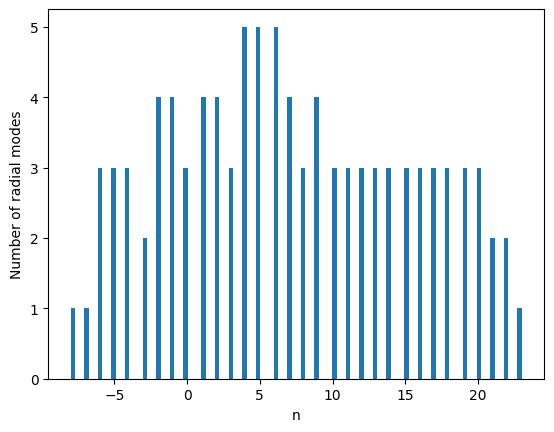

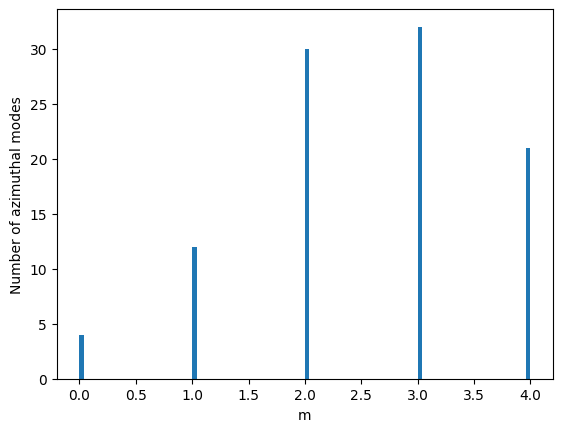

In [7]:
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few import get_file_manager

# produce sensitivity function
noise = np.genfromtxt(get_file_manager().get_file("LPA.txt"), names=True)
f, PSD = (
    np.asarray(noise["f"], dtype=np.float64),
    np.asarray(noise["ASD"], dtype=np.float64) ** 2,
)

sens_fn = CubicSplineInterpolant(f, PSD)

# select modes with noise weighting

# provide sensitivity function kwarg
mode_selector_noise_weighted = ModeSelector(
    amp.l_arr_no_mask, amp.m_arr_no_mask, amp.n_arr_no_mask, sensitivity_fn=sens_fn
)

eps = 1e-2  # tolerance on mode contribution to total power

fund_freq_args = (m1, m2, a, p, e, x, t)

modeinds = [amp.l_arr, amp.m_arr, amp.n_arr]
(teuk_modes_in, ylms_in, ls, ms, ns) = mode_selector_noise_weighted(
    teuk_modes, ylms, modeinds, fund_freq_args=fund_freq_args, mode_selection_threshold=eps
)

print(
    "We reduced the mode content from {} modes to {} modes when using noise-weighting.".format(
        teuk_modes.shape[1], teuk_modes_in.shape[1]
    )
)
# plot histogram of modes
plt.figure()
plt.hist(ns, bins=100, label="n")
plt.xlabel("n")
plt.ylabel("Number of radial modes")
plt.show()

plt.figure()
plt.hist(ms, bins=100, label="n")
plt.xlabel("m")
plt.ylabel("Number of azimuthal modes")
plt.show()

### Compare the two waves with and without noise-weighting

(CubicSplineInterpolant) Warning: New t array outside bounds of input t array. These points are filled with edge values.


mismatch: 0.010325452679436742
base modes: 19
noise-weighted modes: 24


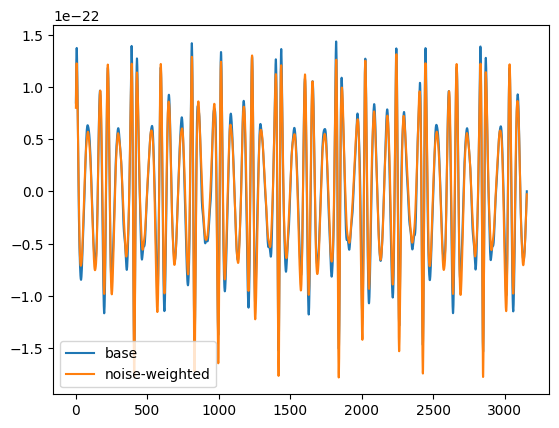

In [10]:
from few.waveform import FastSchwarzschildEccentricFlux
from few.utils.utility import get_mismatch


noise_weighted_mode_selector_kwargs = dict(sensitivity_fn=sens_fn)

inspiral_kwargs = {
    "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
    "buffer_length": int(1e3),  # all of the trajectories will be well under len = 1000
}

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "buffer_length": int(1e3),  # all of the trajectories will be well under len = 1000
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "include_minus_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "pad_output": False,
}

few_base = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
)

few_noise_weighted = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    mode_selector_kwargs=noise_weighted_mode_selector_kwargs,
)

m1 = 1e6
m2 = 1e1
p0 = 12.0
e0 = 0.3
theta = np.pi / 3.0
phi = np.pi / 4.0
dist = 1.0
dt = 10.0
T = 0.001

wave_base = few_base(m1, m2, p0, e0, theta, phi, dist=dist, dt=dt, T=T, mode_selection_threshold=1e-2)
wave_weighted = few_noise_weighted(
    m1, m2, p0, e0, theta, phi, dist=dist, dt=dt, T=T, mode_selection_threshold=1e-2
)

plt.plot(wave_base.real, label="base")
plt.plot(wave_weighted.real, label="noise-weighted")
plt.legend()
print("mismatch:", get_mismatch(wave_base, wave_weighted))
print("base modes:", few_base.num_modes_kept)
print("noise-weighted modes:", few_noise_weighted.num_modes_kept)

### Specific mode selection

The user can also select a specific set of modes to use in the waveform.

(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


mismatch with full wave: 0.04329518222425399


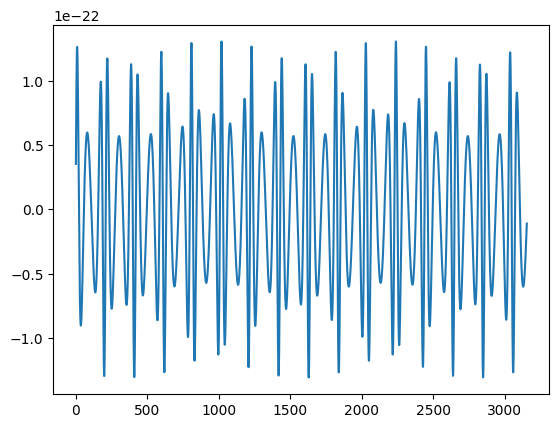

In [11]:
# l = 2, m = 2 wave
specific_modes = [(2, 2, n) for n in range(-30, 31)]

wave_22 = few_base(
    m1, m2, p0, e0, theta, phi, dist=dist, dt=dt, T=T, mode_selection=specific_modes
)

plt.plot(wave_22.real)

print("mismatch with full wave:", get_mismatch(wave_22, wave_base))

### Turn off $(-m, -k, -n)$ modes

By default, symmetry is used to generate $(-m, -k, -n)$ modes from their corresponding $(m, k, n)$ counterparts. To disable this behaviour, provide `False` to the `include_minus_mkn` kwarg. This only affects the waveform when `mode_selection` is a list of specific modes. 

(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


mismatch with 22 wave with + and - m: 0.9986456689591489
mismatch with 22 original wave with adding + and - m 2.220446049250313e-16


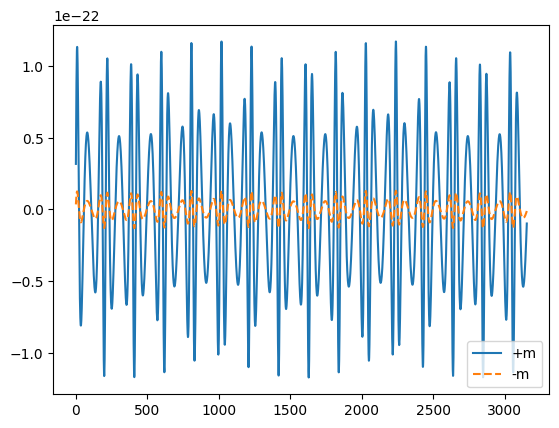

In [12]:
%matplotlib inline
# l = 2, m = 2 wave without m = -2
specific_modes = [(2, 2, n) for n in range(-30, 31)]

specific_modes_minus_m = [(2, -2, n) for n in range(-30, 31)]

wave_22_pos_m = few_base(
    m1,
    m2,
    p0,
    e0,
    theta,
    phi,
    dist=dist,
    dt=dt,
    T=0.001,
    mode_selection=specific_modes,
    include_minus_mkn=False,
)

wave_22_minus_m = few_base(
    m1,
    m2,
    p0,
    e0,
    theta,
    phi,
    dist=dist,
    dt=dt,
    T=0.001,
    mode_selection=specific_modes_minus_m,
    include_minus_mkn=False,
)

plt.plot(wave_22_pos_m.real, label="+m")
plt.plot(wave_22_minus_m.real, label="-m", ls="--")
plt.legend()
print(
    "mismatch with 22 wave with + and - m:",
    get_mismatch(wave_22_minus_m, wave_22_pos_m),
)

print(
    "mismatch with 22 original wave with adding + and - m",
    get_mismatch(wave_22, wave_22_pos_m + wave_22_minus_m),
)